# Model Development

### Table of Contents

* [0.0 Pre-Processing](#prep)
    * [0.1 Split Train-Test](#split)
    * [0.2 Categorical Variables Handling](#cat_hand)
* [1.0 Diagnosis](#diag)
* [2.0 Feature Selection](#feat_selec)
    * [2.1 Low Variance Filter](#variance)
    * [2.2 Wrapper Method](#wrapper)
    * [2.3 Checking Multicollinearity](#check_multi)
* [3.0 Training](#training)
    * [3.1 Hyperparameter Tuning](#hyper)
    * [3.2 Optimized Model](#model)
    * [3.3 Evaluating](#eval) 
    * [3.4 Calibration](#calibration)
    * [3.5 Re-evaluating](#reeval)
    * [3.6 Scoring](#scoring)
* [4.0 Metrics](#metrics)
    * [4.1 Interpretability](#shap)
* [Output](#output) 

In [60]:
# Reload .py auxiliary file
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pickle
import project_utils as pu
import shap
import warnings
from BorutaShap import BorutaShap
from category_encoders.target_encoder import TargetEncoder
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# Options
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the cleaned dataset into a pandas dataframe
df = pd.read_csv('./output/p2p_cleaned.csv', encoding='utf-8')

## 0.0 Pre-Processing <a class="anchor" id="prep"></a>

### 0.1 Split Train-Test <a class="anchor" id="split"></a>

In [7]:
# Divide the data in train and test sets, with the test_set having the last 5% of the data (newest)
X_train, X_test, y_train, y_test = pu.train_test_split_sorted(X=df.drop(['target', 'issue_d'], axis=1),
                                                              y=df['target'],
                                                              test_size=0.05,
                                                              dates=df['issue_d'])

### 0.2 Categorical Variables Handling <a class="anchor" id="cat_hand"></a>

In [8]:
# List of categorical features to be encoded
#cat_columns = list(df.select_dtypes('object').columns)

# Target Encoder object with regularization
encoder = TargetEncoder(smoothing=10)

# Transforming the features after fitting
X_train = encoder.fit_transform(X=X_train, y=y_train)

# Enconding test set
X_test = encoder.transform(X_test)

## 1.0 Diagnosis <a class="anchor" id="diag"></a>

### Random Forest

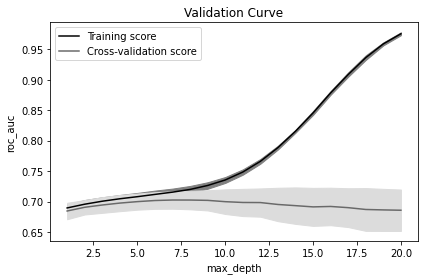

Wall time: 3h 20min 42s


In [187]:
%%time

# Plot Validation Curve using RF as estimator
pu.plot_validation_curve(estimator=RandomForestClassifier(random_state=13),
                         dataframe=X_train,
                         target=y_train,
                         param_name="max_depth",
                         param_range=list(range(1, 21)),
                         cv=3,
                         scoring=None,
                         n_jobs=-1,
                         save_dir='./output/rf_validation_curve.png')

Following the plot above, even though the large uncertainty light gray area on the test score, it is possible to know a good start region of optimization for max_depth - around 10, because from there the roc-auc doesn't increase) 

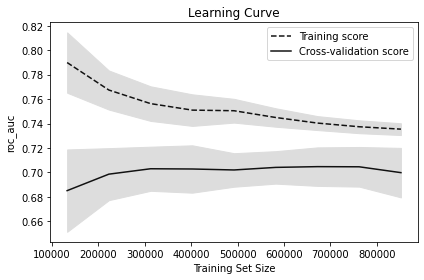

Wall time: 47min 23s


In [189]:
%%time

# Plot Learning Curve using RF as estimator
pu.plot_learning_curve(estimator=RandomForestClassifier(max_depth=10, random_state=13),
                       dataframe=X_train,
                       target=y_train,
                       train_sizes=np.linspace(0.05, 1.0, 10),
                       cv=3,
                       scoring=None,
                       n_jobs=-1,
                       save_dir='./output/rf_learning_curve.png')

In [ ]:
# Comments

### XGBoost

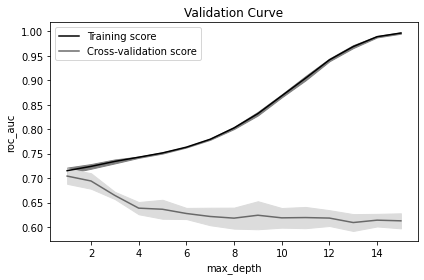

Wall time: 6h 11min 41s


In [228]:
%%time

# Plot Validation Curve using XGB as estimator
pu.plot_validation_curve(estimator=XGBClassifier(random_state=13),
                         dataframe=X_train,
                         target=y_train,
                         param_name="max_depth",
                         param_range=list(range(1, 16)),
                         cv=3,
                         scoring=None,
                         n_jobs=-1,
                         save_dir='./output/xgboost_validation_curve.png')

In [ ]:
# Comments

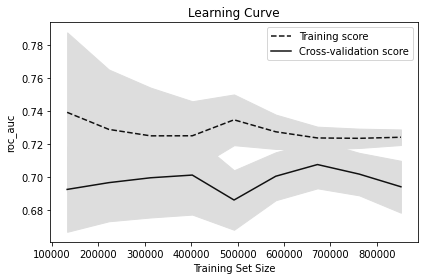

Wall time: 25min 27s


In [190]:
%%time

# Plot Learning Curve using XGB as estimator
pu.plot_learning_curve(estimator=XGBClassifier(max_depth=2, random_state=13),
                       dataframe=X_train,
                       target=y_train,
                       train_sizes=np.linspace(0.05, 1.0, 10),
                       cv=3,
                       scoring=None,
                       n_jobs=-1,
                       save_dir='./output/xgboost_learning_curve.png')

In [ ]:
# Comments

## 2.0 Feature Selection <a class="anchor" id="feat_selec"></a>

### 2.1 Low Variance Filter <a class="anchor" id="variance"></a>

In [5]:
# Removes all features whose variance doesn’t meet the threshold
X_train, rmvd_feat = pu.get_low_variance_columns(dframe=X_train,
                                                 thresh=0.005,
                                                 autoremove=True)

Finding low-variance features.
Found 12 low-variance columns.
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.


In [6]:
# low-variance features
print(rmvd_feat)

['application_type', 'disbursement_method', 'emp_length', 'hardship_flag', 'home_ownership', 'initial_list_status', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'policy_code', 'purpose', 'pymnt_plan', 'verification_status']


### 2.2 Wrapper Method <a class="anchor" id="wrapper"></a>

In [12]:
# Feature selector instance
feature_selector = BorutaShap(model=RandomForestClassifier(random_state=13),
                              importance_measure='shap',
                              classification=True)

feature_selector.fit(X=X_train[-20000:],
                     y=y_train[-20000:],
                     n_trials=25,
                     sample=False,
                     train_or_test = 'test',
                     normalize=True,
                     verbose=True)

100%|█████████████████████████████████████████████████████████████████████████████| 25/25 [32:11:36<00:00, 4635.85s/it]

27 attributes confirmed important: ['fico_range_high', 'fico_range_low', 'num_actv_rev_tl', 'dti', 'bc_open_to_buy', 'mort_acc', 'int_rate', 'revol_util', 'total_bc_limit', 'total_rev_hi_lim', 'term', 'mo_sin_old_il_acct', 'tot_hi_cred_lim', 'total_acc', 'installment', 'mths_since_recent_bc', 'tot_cur_bal', 'mo_sin_old_rev_tl_op', 'inq_last_6mths', 'num_il_tl', 'avg_cur_bal', 'loan_amnt', 'bc_util', 'funded_amnt_inv', 'mths_since_earliest_cr_line', 'funded_amnt', 'annual_inc']
29 attributes confirmed unimportant: ['acc_now_delinq', 'mths_since_recent_inq', 'total_il_high_credit_limit', 'pub_rec_bankruptcies', 'delinq_amnt', 'num_tl_op_past_12m', 'acc_open_past_24mths', 'chargeoff_within_12_mths', 'num_rev_accts', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'total_bal_ex_mort', 'collections_12_mths_ex_med', 'open_acc', 'num_tl_90g_dpd_24m', 'pub_rec', 'num_bc_sats', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_sats', 'num_bc_tl', 'tax_liens', 'percent_bc_gt_75', 'mo_sin_rcnt_tl', 'mths_since_

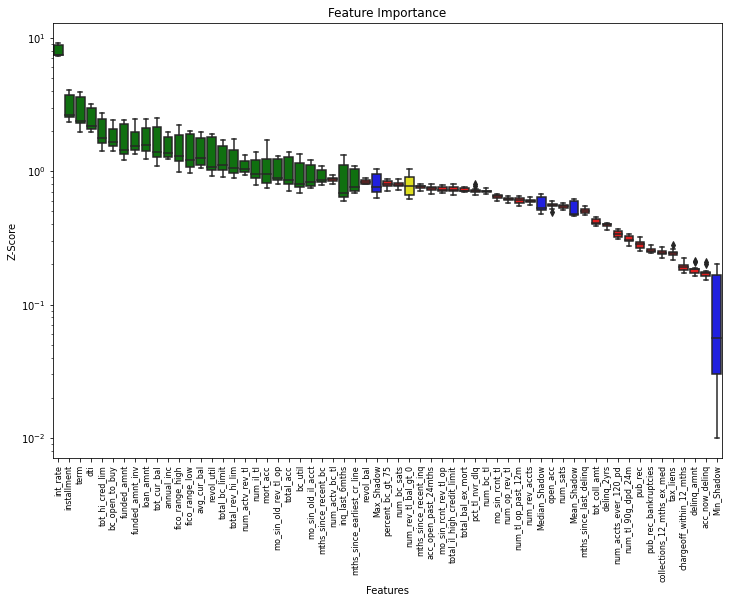

In [13]:
# Returns Boxplot of features
feature_selector.plot(which_features='all')

In [28]:
# Returns a subset of the original data with the selected features
X_train_subset = feature_selector.Subset()

# Get a list of important features
important_feat = list(X_train_subset.columns)

In [9]:
important_feat = ['fico_range_high', 'fico_range_low', 'num_actv_rev_tl', 'dti', 'bc_open_to_buy',
                  'mort_acc', 'int_rate', 'revol_util', 'total_bc_limit', 'total_rev_hi_lim', 'term',
                  'mo_sin_old_il_acct', 'tot_hi_cred_lim', 'total_acc', 'installment', 'mths_since_recent_bc',
                  'tot_cur_bal', 'mo_sin_old_rev_tl_op', 'inq_last_6mths', 'num_il_tl', 'avg_cur_bal',
                  'loan_amnt', 'bc_util', 'funded_amnt_inv', 'mths_since_earliest_cr_line', 'funded_amnt', 'annual_inc']

### 2.3 Checking Multicollinearity <a class="anchor" id="check_multi"></a>

Multicollinearity does not affect the result (prediction) in non-linear models such as tree-based models like RF and XGB, although it may have some bad effects in feature extraction for further analysis, it makes the coefficients (feature importances) unstable and incorrect.

Random Forest will keep them (correlated features) both, because they build the tree independently and random select the feature for every trees.
XGBoost, will choose anyone of them (correlated features) and use it until the last tree build.

In [10]:
# Calculates VIF values
df_vif = pu.sklearn_vif(exogs=important_feat, data=X_train)

# Show VIF values of selected subset
df_vif.apply(lambda x: x.apply('{0:.1f}'.format))

,VIF,Tolerance
fico_range_high,7615863.2,0.0
fico_range_low,7615873.4,0.0
num_actv_rev_tl,1.9,0.5
dti,1.2,0.8
bc_open_to_buy,6.3,0.2
mort_acc,1.8,0.6
int_rate,2.8,0.4
revol_util,2.9,0.3
total_bc_limit,6.8,0.1
total_rev_hi_lim,2.5,0.4


In [11]:
# Drop correlated features -> VIF greater than 10
important_feat.remove('fico_range_high')
important_feat.remove('funded_amnt')
important_feat.remove('funded_amnt_inv')
important_feat.remove('tot_hi_cred_lim')
important_feat.remove('installment')

In [12]:
# Calculates VIF values
df_vif = pu.sklearn_vif(exogs=important_feat, data=X_train)

# Show VIF values of selected subset
df_vif.apply(lambda x: x.apply('{0:.1f}'.format))

,VIF,Tolerance
fico_range_low,1.8,0.5
num_actv_rev_tl,1.9,0.5
dti,1.2,0.8
bc_open_to_buy,6.2,0.2
mort_acc,1.8,0.6
int_rate,1.7,0.6
revol_util,2.9,0.3
total_bc_limit,6.8,0.1
total_rev_hi_lim,2.3,0.4
term,1.4,0.7


In [13]:
# Filter dataset with selected features
X_train_subset = X_train[list(df_vif.index.values)]
X_test_subset = X_test[list(df_vif.index.values)]

## 3.0 Training <a class="anchor" id="training"></a>

### 3.1 Hyperparameter Tuning <a class="anchor" id="hyper"></a>

In [142]:
# Defines the range of input values to test 
# In Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters
space = {'max_depth': hp.choice('max_depth', range(5, 15, 1)),
         'max_features': hp.pchoice('max_features', [(0.5, 'sqrt'), # most common choice
                                                     (0.4, 'log2'), # less common choice
                                                     (0.1, None)]), # rare choice
         'min_samples_leaf': hp.quniform ('min_samples_leaf', 1, 5, 1),
         'min_samples_split' : hp.quniform ('min_samples_split', 2, 12, 1),
         'n_estimators' : hp.choice('n_estimators', range(10, 510, 10))}

In [143]:
# Defines the loss function to minimize
def objective(space):
    # instantiate the algorithm
    rf_classifier = RandomForestClassifier(n_estimators=int(space['n_estimators']),
                                           max_depth=int(space['max_depth']),
                                           max_features=space['max_features'],
                                           min_samples_split=int(space['min_samples_split']),
                                           min_samples_leaf=int(space['min_samples_leaf']),
                                           class_weight='balanced')
    
    #print(classifier)
    # Use Cross validation to compute score
    cv_score = cross_val_score(estimator=rf_classifier,
                               X=X_train_subset[-300000:],
                               y=y_train[-300000:],
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=-1,
                               error_score='raise')
    
    # Calculate roc_auc mean on the folds
    mean_cv_score = cv_score.mean()
    
    #print('Cross Validate Mean:', mean_cv_score)
    
    return {'loss': 1-mean_cv_score, 'status': STATUS_OK}

In [144]:
# Defines the search algorithm to use, to select the best input values in each new iteration
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=70,
            trials=trials,
            rstate=np.random.default_rng(13),
            return_argmin=True # set false to get the real value instead of index
           )

100%|█████████████████████████████████████████████| 70/70 [4:58:20<00:00, 255.73s/trial, best loss: 0.2941493688543817]


### 3.2 Optimized Model <a class="anchor" id="model"></a>

In [230]:
%%time

# Training a Random Forest with optimized hyperparameters
model = RandomForestClassifier(n_estimators=range(10, 510, 10)[best['n_estimators']],
                               max_depth=range(5, 15, 1)[best['max_depth']],
                               max_features=['sqrt', 'log2', None][best['max_features']],
                               min_samples_split=int(best['min_samples_split']),
                               min_samples_leaf=int(best['min_samples_leaf']),
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=13)

model.fit(X_train_subset[-300000:], y_train[-300000:])

Wall time: 3min 13s


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=11, n_estimators=470, n_jobs=-1,
                       random_state=13)

In [5]:
with open('./output/rf_model_pkl.sav', 'rb') as file:
    model = pickle.load(file)

### 3.3 Evaluating <a class="anchor" id="eval"></a>

In [14]:
%%time

# Classifies the data used in training
y_train_pred = model.predict(X_train_subset[-300000:])

# Classifies the test dataset
y_test_pred = model.predict(X_test_subset)

Wall time: 15.5 s


In [15]:
# Calculate the model accuracy in training
train_accuracy = round(accuracy_score(y_train[-300000:], y_train_pred) * 100, 2)

# Calculate the model accuracy in test
test_accuracy = round(accuracy_score(y_test, y_test_pred) * 100, 2)

print('Train Accuracy: ' + str(train_accuracy) + '%')
print('Test Accuracy: ' + str(test_accuracy) + '%')

Train Accuracy: 70.53%
Test Accuracy: 68.57%


In [249]:
# Get precision, recall, f1-score and support for train dataset
pu.classification_report_df(y_train[-300000:], y_train_pred, target_names=['Unpaid', 'Paid'])

,precision,recall,f1-score,support
Unpaid,0.43,0.72,0.54,72142.00
Paid,0.89,0.70,0.78,227858.00
accuracy,0.71,0.71,0.71,0.71
macro avg,0.66,0.71,0.66,300000.00
weighted avg,0.78,0.71,0.72,300000.00


In [250]:
# Get precision, recall, f1-score and support for test dataset
pu.classification_report_df(y_test, y_test_pred, target_names=['Unpaid', 'Paid'])

,precision,recall,f1-score,support
Unpaid,0.29,0.59,0.39,11226.00
Paid,0.90,0.70,0.79,56042.00
accuracy,0.69,0.69,0.69,0.69
macro avg,0.59,0.65,0.59,67268.00
weighted avg,0.79,0.69,0.72,67268.00


### 3.4 Calibration <a class="anchor" id="calibration"></a>

In [16]:
# Make predictions (probability)
predictions = model.predict_proba(X_test_subset)

In [77]:
%%time

# Calibrates the model
clf = RandomForestClassifier(class_weight='balanced', max_depth=12,
                             max_features='sqrt', min_samples_leaf=5,
                             min_samples_split=11, n_estimators=470, n_jobs=-1,
                             random_state=13)

cal_model = CalibratedClassifierCV(clf, method='sigmoid', cv=3, n_jobs=-1)
cal_model.fit(X_train_subset[-300000:], y_train[-300000:])

Wall time: 5min 55s


CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                             max_depth=12,
                                                             max_features='sqrt',
                                                             min_samples_leaf=5,
                                                             min_samples_split=11,
                                                             n_estimators=470,
                                                             n_jobs=-1,
                                                             random_state=13),
                       cv=3, n_jobs=-1)

In [90]:
# Make calibrated predictions (probability)
cal_predictions = cal_model.predict_proba(X_test_subset)

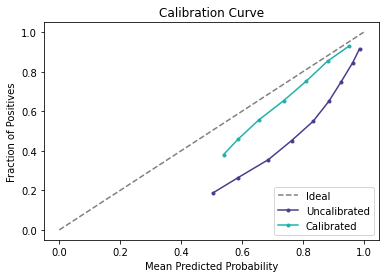

In [106]:
# Plot Calibration Curve
pu.plot_calibration_curve(y_test, predictions[:, 1], cal_predictions[:, 1], './output/calibration_curve.png')

### 3.5 Re-evaluating <a class="anchor" id="reeval"></a>

In [92]:
%%time

# Classifies the data used in training
caly_train_pred = cal_model.predict(X_train_subset[-300000:])

# Classifies the test dataset
caly_test_pred = cal_model.predict(X_test_subset)

Wall time: 47.3 s


In [93]:
# Get precision, recall, f1-score and support for train dataset
pu.classification_report_df(y_train[-300000:], caly_train_pred, target_names=['Unpaid', 'Paid'])

,precision,recall,f1-score,support
Unpaid,0.69,0.14,0.23,72142.00
Paid,0.78,0.98,0.87,227858.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.74,0.56,0.55,300000.00
weighted avg,0.76,0.78,0.72,300000.00


In [94]:
# Get precision, recall, f1-score and support for test dataset
pu.classification_report_df(y_test, caly_test_pred, target_names=['Unpaid', 'Paid'])

,precision,recall,f1-score,support
Unpaid,0.42,0.09,0.15,11226.00
Paid,0.84,0.98,0.90,56042.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.63,0.53,0.53,67268.00
weighted avg,0.77,0.83,0.78,67268.00


### 3.6 Scoring <a class="anchor" id="scoring"></a>

In [95]:
# Scoring how likely each loan will be paid - logit
scores = pd.Series(map(lambda p: int(round(math.log(p[1] / (1 - p[1])) * 100 + 500, 0)), cal_predictions))

In [96]:
# Create and save DataFrame with scores and true values (ground truth)
df_scores = pd.concat([scores.reset_index(drop=True).rename('score'),
                       y_test.reset_index(drop=True).rename('target')],
                       axis=1)

df_scores.to_csv('./output/scores.csv', index=False)

## 4.0 Metrics <a class="anchor" id="metrics"></a>

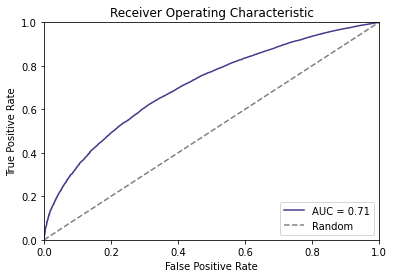

In [105]:
# Plot roc curve and compute auc score
pu.plot_roc_curve(y_test, cal_predictions, './output/roc_curve.png')

In [107]:
# Calculates KS and lift
df_ks, ks = pu.get_performance(scores, y_test)

# Show KS
ks

'KS is 30.6% at decile 6'

In [108]:
# Save performance dataframe
df_ks.to_csv('./output/ks_report.csv', index=False)

# Show performance dataframe
df_ks

,min_score,max_score,event,nonevent,dec_pop,dec_eventrate,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,lift,ks
decile,,,,,,,,,,,,
1,768,828,6532,171,6703,97.45%,11.66%,1.52%,11.66%,1.52%,1.17,10.1
2,732,767,6251,392,6643,94.10%,11.15%,3.49%,22.81%,5.02%,1.13,17.8
3,702,731,6161,556,6717,91.72%,10.99%,4.95%,33.80%,9.97%,1.10,23.8
4,674,701,5966,731,6697,89.08%,10.65%,6.51%,44.45%,16.48%,1.07,28.0
5,646,673,5894,960,6854,85.99%,10.52%,8.55%,54.97%,25.03%,1.03,29.9
6,620,645,5670,1064,6734,84.20%,10.12%,9.48%,65.08%,34.51%,1.01,30.6
7,595,619,5422,1303,6725,80.62%,9.67%,11.61%,74.76%,46.12%,0.97,28.6
8,568,594,5052,1602,6654,75.92%,9.01%,14.27%,83.77%,60.39%,0.91,23.4
9,535,567,4772,1890,6662,71.63%,8.52%,16.84%,92.29%,77.22%,0.86,15.1


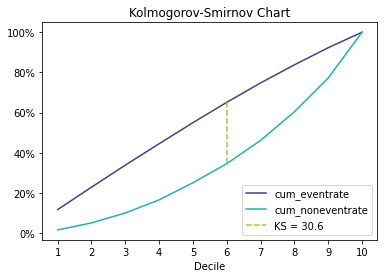

In [109]:
# Plot and save KS Chart
pu.plot_ks(df_ks, './output/ks_chart.png')

### 4.1 Interpretability <a class="anchor" id="shap"></a>

In [159]:
%%time

# Compute SHAP values
data = shap.kmeans(X_train_subset[-300000:], 10)

explainer = shap.KernelExplainer(cal_model.predict_proba, data, link='logit')
shap_values = explainer.shap_values(X_test_subset, nsamples=100, l1_reg='num_features(10)')

100%|█████████████████████████████████████████████████████████████████████████| 67268/67268 [20:16:32<00:00,  1.09s/it]


Wall time: 20h 17min 11s


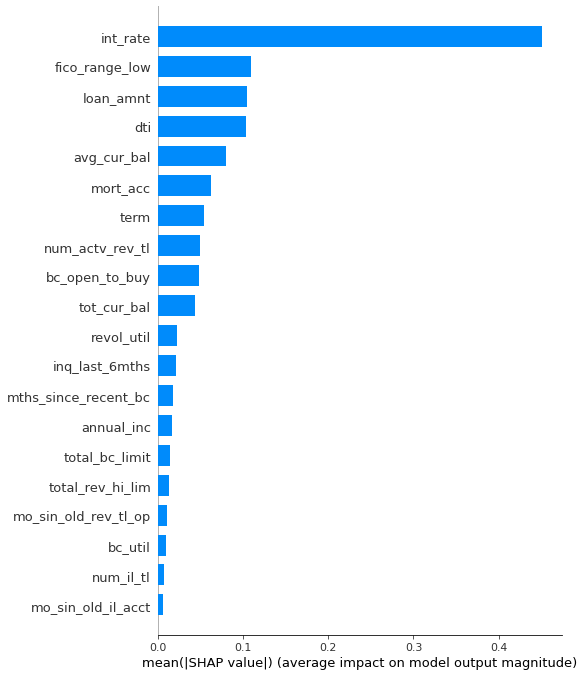

In [161]:
# Feature importance chart
f = plt.figure()

shap.summary_plot(shap_values[1], X_test_subset, plot_type='bar')

f.savefig('./output/feat_importance.png', bbox_inches='tight', dpi=600)

SHAP feature importance measured as the mean absolute Shapley values. The interest rates was the most important feature, changing the predicted loan payment probability on average by 45 log-odds units.

"SHAP is based on magnitude of feature attributions".

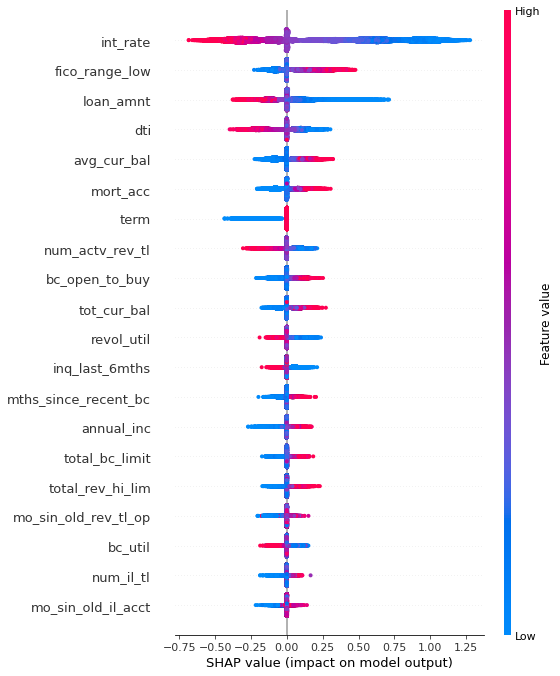

In [164]:
# Plot and save SHAP summary chart
f = plt.figure()

shap.summary_plot(shap_values[1], X_test_subset)

f.savefig('./output/summary_plot.png', bbox_inches='tight', dpi=600)

In [165]:
# Calcs feature importance
df_shap = pu.shap_feature_importance(X_test_subset, shap_values)

# Save
df_shap.to_csv('./output/feat_importance.csv', index=False)

# Show
df_shap

,feature_name,feature_importance_value
1,int_rate,0.451464
2,fico_range_low,0.109420
3,loan_amnt,0.103989
4,dti,0.103448
5,avg_cur_bal,0.079390
6,mort_acc,0.062176
7,term,0.053397
8,num_actv_rev_tl,0.049062
9,bc_open_to_buy,0.048458
10,tot_cur_bal,0.043537


# Output <a class="anchor" id="model_output"></a>

In [163]:
# Save model as pickle
with open('./output/rf_model_pkl.sav', 'wb') as file:
    pickle.dump(model, file)
    
# Save encoder as pickle
with open('./output/tg_encoder_pkl.sav', 'wb') as file:
    pickle.dump(encoder, file)